In [2]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt 
from datetime import datetime

import lightgbm as lgb 

from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import log_loss

In [3]:
pd.set_option('display.max_columns', 500)

# read data 

In [4]:
train = pd.read_table('./data/round1_ijcai_18_train_20180301.txt', sep=' ')
test = pd.read_table('./data/round1_ijcai_18_test_b_20180418.txt', sep=' ')
train = train.sort_values(by='context_timestamp').reset_index(drop=True)

In [5]:
train.dtypes

instance_id                    int64
item_id                        int64
item_category_list            object
item_property_list            object
item_brand_id                  int64
item_city_id                   int64
item_price_level               int64
item_sales_level               int64
item_collected_level           int64
item_pv_level                  int64
user_id                        int64
user_gender_id                 int64
user_age_level                 int64
user_occupation_id             int64
user_star_level                int64
context_id                     int64
context_timestamp              int64
context_page_id                int64
predict_category_property     object
shop_id                        int64
shop_review_num_level          int64
shop_review_positive_rate    float64
shop_star_level                int64
shop_score_service           float64
shop_score_delivery          float64
shop_score_description       float64
is_trade                       int64
d

In [20]:
train.head()

,item_price_level,item_sales_level,item_collected_level,item_pv_level,user_age_level,shop_review_num_level,shop_review_positive_rate,shop_star_level,shop_score_service,shop_score_delivery,shop_score_description,is_trade,plus_item_sales_level_item_collected_level,minus_item_sales_level_item_collected_level,mult_item_sales_level_item_collected_level,div1_item_sales_level_item_collected_level,div0_item_sales_level_item_collected_level,plus_item_sales_level_item_pv_level,minus_item_sales_level_item_pv_level,mult_item_sales_level_item_pv_level,div1_item_sales_level_item_pv_level,div0_item_sales_level_item_pv_level,plus_item_sales_level_user_age_level,minus_item_sales_level_user_age_level,mult_item_sales_level_user_age_level,div1_item_sales_level_user_age_level,div0_item_sales_level_user_age_level,plus_item_sales_level_user_star_level,minus_item_sales_level_user_star_level,mult_item_sales_level_user_star_level,div1_item_sales_level_user_star_level,div0_item_sales_level_user_star_level,plus_item_sales_level_shop_review_num_level,minus_item_sales_level_shop_review_num_level,mult_item_sales_level_shop_review_num_level,div1_item_sales_level_shop_review_num_level,div0_item_sales_level_shop_review_num_level,plus_item_sales_level_shop_review_positive_rate,minus_item_sales_level_shop_review_positive_rate,mult_item_sales_level_shop_review_positive_rate,div1_item_sales_level_shop_review_positive_rate,div0_item_sales_level_shop_review_positive_rate,plus_item_sales_level_shop_star_level,minus_item_sales_level_shop_star_level,mult_item_sales_level_shop_star_level,div1_item_sales_level_shop_star_level,div0_item_sales_level_shop_star_level,plus_item_collected_level_item_pv_level,minus_item_collected_level_item_pv_level,mult_item_collected_level_item_pv_level,div1_item_collected_level_item_pv_level,div0_item_collected_level_item_pv_level,plus_item_collected_level_user_age_level,minus_item_collected_level_user_age_level,mult_item_collected_level_user_age_level,div1_item_collected_level_user_age_level,div0_item_collected_level_user_age_level,plus_item_collected_level_user_star_level,minus_item_collected_level_user_star_level,mult_item_collected_level_user_star_level,div1_item_collected_level_user_star_level,div0_item_collected_level_user_star_level,plus_item_collected_level_shop_review_num_level,minus_item_collected_level_shop_review_num_level,mult_item_collected_level_shop_review_num_level,div1_item_collected_level_shop_review_num_level,div0_item_collected_level_shop_review_num_level,plus_item_collected_level_shop_review_positive_rate,minus_item_collected_level_shop_review_positive_rate,mult_item_collected_level_shop_review_positive_rate,div1_item_collected_level_shop_review_positive_rate,div0_item_collected_level_shop_review_positive_rate,plus_item_collected_level_shop_star_level,minus_item_collected_level_shop_star_level,mult_item_collected_level_shop_star_level,div1_item_collected_level_shop_star_level,div0_item_collected_level_shop_star_level,plus_item_pv_level_user_age_level,minus_item_pv_level_user_age_level,mult_item_pv_level_user_age_level,div1_item_pv_level_user_age_level,div0_item_pv_level_user_age_level,plus_item_pv_level_user_star_level,minus_item_pv_level_user_star_level,mult_item_pv_level_user_star_level,div1_item_pv_level_user_star_level,div0_item_pv_level_user_star_level,plus_item_pv_level_shop_review_num_level,minus_item_pv_level_shop_review_num_level,mult_item_pv_level_shop_review_num_level,div1_item_pv_level_shop_review_num_level,div0_item_pv_level_shop_review_num_level,plus_item_pv_level_shop_review_positive_rate,minus_item_pv_level_shop_review_positive_rate,mult_item_pv_level_shop_review_positive_rate,div1_item_pv_level_shop_review_positive_rate,div0_item_pv_level_shop_review_positive_rate,plus_item_pv_level_shop_star_level,minus_item_pv_level_shop_star_level,mult_item_pv_level_shop_star_level,div1_item_pv_level_shop_star_level,div0_item_pv_level_shop_star_level,plus_user_age_level_user_star_level,minus_user_age_level_user_star_

# new features 

In [6]:
train['user_star_level'] = train['user_star_level'] - 3000
test['user_star_level'] = test['user_star_level'] - 3000

train['shop_star_level'] = train['shop_star_level'] - 5000
test['shop_star_level'] = test['shop_star_level'] - 5000

train['user_age_level'] = train['user_age_level'] - 1000
test['user_age_level'] = test['user_age_level'] - 1000

lvl_cols = []
for i in train.columns: 
    if (('_level' in i) | ('rate' in i)):
        lvl_cols.append(i)

### float cols interactions 

In [7]:
def mult_stats(df):

    for i1 in range(1,len(lvl_cols)-1):
        for j1 in range(i1+1,len(lvl_cols)):
            
            i = lvl_cols[i1]
            j = lvl_cols[j1]
            
            print(i,j)
            
            df['plus_'+i+'_'+j] = df[i] + df[j]
            df['minus_'+i+'_'+j] = df[i] - df[j]
            df['mult_'+i+'_'+j] = df[i] * df[j]
            df['div1_'+i+'_'+j] = df[i] / (df[j]+1)
            df['div0_'+i+'_'+j] = df[j] / (df[i]+1)
            
    return df

train = mult_stats(train)
test = mult_stats(test)

item_sales_level item_collected_level
item_sales_level item_pv_level
item_sales_level user_age_level
item_sales_level user_star_level
item_sales_level shop_review_num_level
item_sales_level shop_review_positive_rate
item_sales_level shop_star_level
item_collected_level item_pv_level
item_collected_level user_age_level
item_collected_level user_star_level
item_collected_level shop_review_num_level
item_collected_level shop_review_positive_rate
item_collected_level shop_star_level
item_pv_level user_age_level
item_pv_level user_star_level
item_pv_level shop_review_num_level
item_pv_level shop_review_positive_rate
item_pv_level shop_star_level
user_age_level user_star_level
user_age_level shop_review_num_level
user_age_level shop_review_positive_rate
user_age_level shop_star_level
user_star_level shop_review_num_level
user_star_level shop_review_positive_rate
user_star_level shop_star_level
shop_review_num_level shop_review_positive_rate
shop_review_num_level shop_star_level
shop_review_p

### categorical columns counters and mean encoding 

In [8]:
def counter(df_train, df_test):
    
    cat_cols = [
        'item_id', 
        'item_brand_id', 
        'item_city_id', 
        'user_id', 
        'shop_id']
    
    all_data = pd.concat([df_train.drop('is_trade',axis=1),df_test],axis=0)
    
    for i in cat_cols:
        
        # fraction of categories that are in train, but not in test 
        non_in_test = len(set(train[i]) - set(test[i]) ) / len(set(train[i]))
        print(i, non_in_test)
        
        temp = all_data[[i,'instance_id']].groupby(i).agg('count').reset_index()
        temp.columns = [i, i+'_counts']

        df_train = pd.merge(df_train, temp, how='left', on=i)
        df_test = pd.merge(df_test, temp, how='left', on=i)
      
    # --------------------------------------------------------- #

    # all this categories are both in train and test 
    cat_cols = [
        'user_gender_id',
       'user_occupation_id', 
        'user_star_level', 
       'context_page_id']
    
    for i in cat_cols:
        
        non_in_test = len(set(train[i]) - set(test[i]) ) / len(set(train[i]))
        print(i, non_in_test)
        
        temp = train[[i,'is_trade']].groupby(i).agg('mean').reset_index()
        temp.columns = [i, i+'_mean']

        df_train = pd.merge(df_train, temp, how='left', on=i)
        df_test = pd.merge(df_test, temp, how='left', on=i)
        
    return df_train, df_test 

train, test = counter(train, test)

item_id 0.533498759305211
item_brand_id 0.37664233576642336
item_city_id 0.140625
user_id 0.9692909243578459
shop_id 0.3963122000505178
user_gender_id 0.0
user_occupation_id 0.0
user_star_level 0.0
context_page_id 0.0


In [9]:
# len of 'predict_category_property' 
def len_values(x):
    a = str(x).split(';')
    return len(a)

train['len_predict_category_property'] = train['predict_category_property'].apply(lambda x: len_values(x))
test['len_predict_category_property'] = test['predict_category_property'].apply(lambda x: len_values(x))

In [10]:
def values(x):
    a = str(x).split(';')
    t = []
    for i in a:
        t.append(i.split(':')[0])
    return ' '.join(t)

In [11]:
# is value of categories interaction is equal to the most common value of this interaction

from scipy.stats import mode
def ret_mode(x):
    m = len(x)
    if(len(x)>=3):
        m, c = mode(x)
    return m

def mode_maker(df_train, df_test, i1, i2):
    
    all_data = pd.concat([df_train[[i1,i2]],df_test[[i1,i2]]],axis=0)
    temp = all_data[[i1,i2]].groupby(i1).agg(ret_mode).reset_index()
    temp.columns = [i1, i2+'_mode']
    
    df_train = pd.merge(df_train, temp, how='left', on=i1)
    df_test = pd.merge(df_test, temp, how='left', on=i1)
    
    df_train[i1+'_mode_'+i2] = (df_train[i2] == df_train[i2+'_mode']) * 1
    df_test[i1+'_mode_'+i2] = (df_test[i2] == df_test[i2+'_mode']) * 1
    
    df_train = df_train.drop(i2+'_mode', axis=1)
    df_test = df_test.drop(i2+'_mode', axis=1)
    
    return df_train , df_test

# ---------------------------------------------- # 

i1 = 'item_brand_id'
i2 = 'shop_id'
train, test = mode_maker(train, test, i1, i2)

i2 = 'item_brand_id'
i1 = 'shop_id'
train, test = mode_maker(train, test, i1, i2)

i1 = 'item_id'
i2 = 'shop_id'
train, test = mode_maker(train, test, i1, i2)

i2 = 'item_id'
i1 = 'shop_id'
train, test = mode_maker(train, test, i1, i2)

### tfidf on 'string' features 

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

i = 'item_property_list'
train[i] = train[i].apply(lambda x: ' '.join(str(x).split(';')))
test[i] = test[i].apply(lambda x: ' '.join(str(x).split(';')))
all_data = pd.concat([train[[i]],test[[i]]],axis=0)

count_vect = TfidfVectorizer(input='content', encoding='utf-8', decode_error='strict', 
                             tokenizer=lambda x: x.split(' '), min_df=0.005, use_idf=False)
count_vect.fit(all_data[i].astype('str'))
train_text_temp = pd.DataFrame(count_vect.transform(train[i].astype('str')).todense())
test_text_temp = pd.DataFrame(count_vect.transform(test[i].astype('str')).todense())
new_cols = []

for i in range(train_text_temp.shape[1]):
    new_cols.append('a'+str(i))
train_text_temp.columns = new_cols
test_text_temp.columns = new_cols
print(train_text_temp.shape)

train = pd.concat([train,train_text_temp], axis=1)
test = pd.concat([test,test_text_temp], axis=1)

(478138, 418)


In [13]:
i = 'predict_category_property'
all_data = pd.concat([train[[i]],test[[i]]],axis=0)

count_vect = TfidfVectorizer(input='content', encoding='utf-8', decode_error='strict', 
                             tokenizer=lambda x: x.split(';'), min_df=0.001, use_idf=False)
count_vect.fit(all_data[i].astype('str'))
train_text_temp = pd.DataFrame(count_vect.transform(train[i].astype('str')).todense())
test_text_temp = pd.DataFrame(count_vect.transform(test[i].astype('str')).todense())
new_cols = []

for i in range(train_text_temp.shape[1]):
    new_cols.append('b'+str(i))
train_text_temp.columns = new_cols
test_text_temp.columns = new_cols
print(train_text_temp.shape)

train = pd.concat([train,train_text_temp], axis=1)
test = pd.concat([test,test_text_temp], axis=1)

(478138, 290)


In [14]:
# even if this feature is category, CountVectorizer worked better 
i = 'item_category_list'
all_data = pd.concat([train[[i]],test[[i]]],axis=0)

count_vect = CountVectorizer(input='content', encoding='utf-8', decode_error='strict', 
                             tokenizer=lambda x: x.split(';'))
count_vect.fit(all_data[i].astype('str'))
train_text_temp = pd.DataFrame(count_vect.transform(train[i].astype('str')).todense())
test_text_temp = pd.DataFrame(count_vect.transform(test[i].astype('str')).todense())
new_cols = []

for i in range(train_text_temp.shape[1]):
    new_cols.append('c'+str(i))
train_text_temp.columns = new_cols
test_text_temp.columns = new_cols
print(train_text_temp.shape)

train = pd.concat([train,train_text_temp], axis=1)
test = pd.concat([test,test_text_temp], axis=1)

(478138, 16)


### working with time 

In [15]:
%%time
def convert_to_time(df):
    df['context_timestamp'] = df['context_timestamp'].apply(lambda x: datetime.fromtimestamp(x))
    df['day_of_week'] = df['context_timestamp'].apply(lambda x: x.weekday())
    df['hour'] = df['context_timestamp'].apply(lambda x: x.hour)
    df['minute'] = df['context_timestamp'].apply(lambda x: x.minute)
    df['second'] = df['context_timestamp'].apply(lambda x: x.second)
    df['seconds_since_24.00'] = df['hour']*3600 + df['minute']*60 + df['second']
    
    to_droop = []
    for i in df.columns:
        if (df[i].dtypes=='O'):
            to_droop.append(i)
            
    df = df.drop(to_droop, axis=1)
    #df = df.drop('context_timestamp', axis=1)
    
    return df
train = convert_to_time(train)
test = convert_to_time(test)

Wall time: 19.2 s


### drop useless columns 

In [16]:
cat_cols = [
    'item_id', 
       'item_brand_id', 'item_city_id', 
       'user_id', 'user_gender_id',
       'user_occupation_id', 'user_star_level', 
       'context_page_id', 
       'shop_id',
           
    
    'minute', 'second',
    'context_timestamp',      
    'instance_id', 'context_id'   # useless 
           ]

train = train.drop(cat_cols, axis=1)
test = test.drop(cat_cols, axis=1)

In [17]:
# drop columns with 1 unique value 
print(train.shape)
features_q = train.shape[1]
feat = train.nunique()
non_unique = feat[feat < 2].index

train = train.drop(non_unique,axis=1)
test = test.drop(non_unique,axis=1)
print(train.shape)

(478138, 893)
(478138, 892)


# ML model 

In [18]:
data_train = lgb.Dataset(train.drop('is_trade',axis=1), 
                             label=train['is_trade'], 
                             #categorical_feature=cat_cols, 
                             free_raw_data=True)

### cv

In [19]:
params = {
    'objective':'binary', 
    'metrics':'binary_logloss',
    'learning_rate': 0.01, 
    'random_state':4242442,
    'reg_lambda':3
}

h = lgb.cv(params, data_train, num_boost_round=10000, nfold=5, verbose_eval=10,
           stratified=False, shuffle=False, early_stopping_rounds=50)

[10]	cv_agg's binary_logloss: 0.608605 + 0.000251115
[20]	cv_agg's binary_logloss: 0.538401 + 0.000484693
[30]	cv_agg's binary_logloss: 0.479351 + 0.000707167
[40]	cv_agg's binary_logloss: 0.429186 + 0.00091819
[50]	cv_agg's binary_logloss: 0.38623 + 0.00113248
[60]	cv_agg's binary_logloss: 0.349217 + 0.00134257
[70]	cv_agg's binary_logloss: 0.317159 + 0.00154071
[80]	cv_agg's binary_logloss: 0.289278 + 0.00173416
[90]	cv_agg's binary_logloss: 0.264944 + 0.00192283
[100]	cv_agg's binary_logloss: 0.243649 + 0.0021053
[110]	cv_agg's binary_logloss: 0.224973 + 0.00228087
[120]	cv_agg's binary_logloss: 0.208565 + 0.00245071
[130]	cv_agg's binary_logloss: 0.194129 + 0.0026169
[140]	cv_agg's binary_logloss: 0.181413 + 0.00277942
[150]	cv_agg's binary_logloss: 0.170205 + 0.00293713
[160]	cv_agg's binary_logloss: 0.160321 + 0.00309096
[170]	cv_agg's binary_logloss: 0.151603 + 0.00324082
[180]	cv_agg's binary_logloss: 0.143911 + 0.00338471
[190]	cv_agg's binary_logloss: 0.137129 + 0.00352593
[2

### train 

In [21]:
model = lgb.train(params, data_train, num_boost_round=1090)

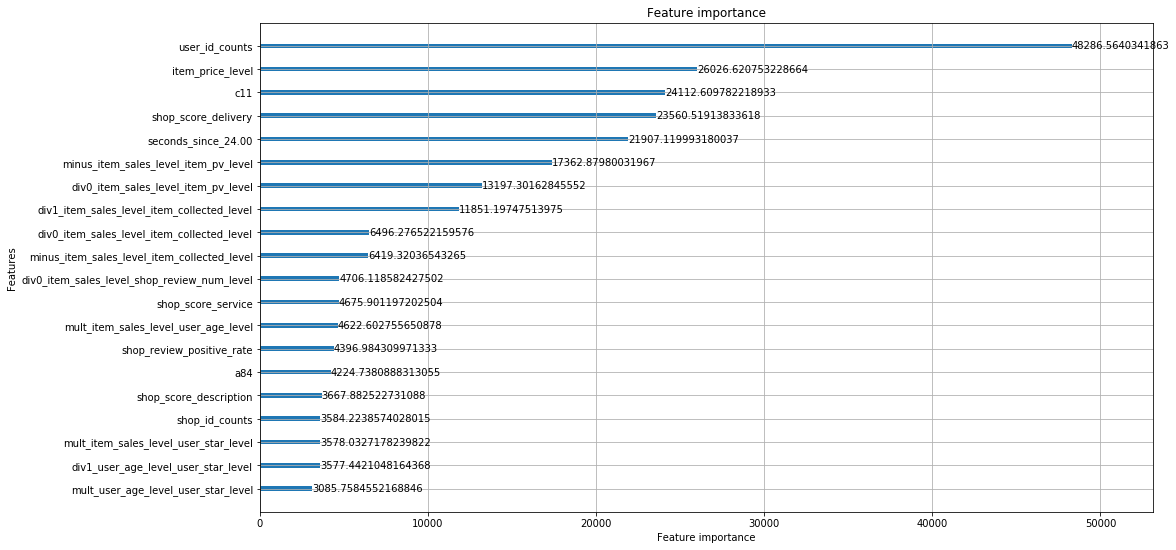

In [22]:
lgb.plot_importance(model, max_num_features=20, importance_type='gain', figsize=(16,9))

### probing 

In [23]:
C = 0.7 # constant sub 
L = 1.18862 # result of constant sub 
y_public_mean = (-L - np.log(1-C)) / (np.log(C) - np.log(1-C))

### make prediction

In [24]:
y_hat = model.predict(test)

In [25]:
prob_coef = y_public_mean/np.mean(y_hat)

print('Mean of prediction: ', np.mean(y_hat))
print('Mean of "public" lb: ', y_public_mean)
print('Correction coef: ', prob_coef)

Mean of prediction:  0.019673758576563356
Mean of "public" lb:  0.018119725121127847
Correction coef:  0.9210098340188655


In [27]:
test = pd.read_table('./data/round1_ijcai_18_test_b_20180418.txt', sep=' ')
pred = pd.DataFrame({
    'instance_id':test['instance_id'],
    'predicted_score':y_hat * prob_coef
})
pred.to_csv('./subs/sub3.txt',index=False, sep=' ')